## Input

In [76]:
import pandas as pd
df = pd.read_csv(r'C:\Users\Morga\programsMG\NaturalLanguageProcessing\preprocessed_kindle_review.csv')

 ## Preprocessing

In [77]:
M = df['reviewText'].tolist()
y = df['rating'].tolist()

In [78]:
import re
X=[]
for item in M:
    X.append(re.sub(r'([a-zA-Z0-9_<>-])\1+', r'\1\1', item))

## Vectorization

In [79]:
from nltk.tokenize import word_tokenize 

textdocuments=[]
for item in X:
    x = word_tokenize(item)
    textdocuments.append(x)  

In [80]:
def merge(list1, list2):
    merged_list = [(list1 [i], list2 [i]) for i in range (0, len(list1))]
    return merged_list

In [81]:
documents = merge(textdocuments,y) 

## Original bigram mnb model

In [82]:
bigram_featuresets_df = pd.read_csv(r'C:\Users\Morga\programsMG\NaturalLanguageProcessing\bigram_featuresets.csv')

In [83]:
X_bifs=bigram_featuresets_df.drop('class',axis=1)

In [84]:
# import the module
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import numpy as np
# initialize the model
mnb1_bifs = MultinomialNB()

In [85]:
# use the training data to train the model
mnb_model_bifs = mnb1_bifs.fit(X_bifs,y)
#cross validation score
mnb_cv_scores_bifs = cross_val_score(mnb1_bifs, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs = round(np.mean(mnb_cv_scores_bifs),4)
print(mnb_cv_score_bifs)

0.4946


## Original Ngram mnb model

In [86]:

# initialize the  model
mnb2 = MultinomialNB()

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
ngram_tfidf_vectorizer_mnb = TfidfVectorizer(encoding='latin-1'
                                                 ,ngram_range=(1,2)
                                                 , use_idf=True
                                                 , min_df=5
                                                 , max_features=3000
                                                )

In [88]:
# fitting and transforming the training data using the count vectorizer
X_train_mnb_2 = ngram_tfidf_vectorizer_mnb.fit_transform(X)

In [89]:
# use the training data to train the model
#mnb_model_2 = mnb2.fit(X_train_mnb_2,y)
#cross validation score
mnb_cv_scores_2 = cross_val_score(mnb2, X_train_mnb_2, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_2 = round(np.mean(mnb_cv_scores_2),4)
print(mnb_cv_score_2)

0.5136


## Vader

In [90]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
#setting an empty list to save the compound scores into.
vs_list_compound = [] 
#Looping through to get a compound score for each tweet saving it into the compund list created.
for review in X:
    vs = analyzer.polarity_scores(review)
    vs_list = vs['compound']
    vs_list_compound.append(vs_list) 
    

In [91]:
import numpy as np
sent_array = np.asarray(vs_list_compound)
sent_norm = (sent_array - sent_array.min())/ (sent_array.max() - sent_array.min())

## subjectivity

In [92]:
SLpath = r"C:\Users\Morga\programsMG\NaturalLanguageProcessing\subjclueslen1-HLTEMNLP05.tff"

In [93]:
# this function returns a dictionary where you can look up words and get back 
#     the four items of subjectivity information described above
def readSubjectivity(path):
    flexicon = open(path, 'r')
    # initialize an empty dictionary
    sldict = { }
    for line in flexicon:
        fields = line.split()   # default is to split on whitespace
        # split each field on the '=' and keep the second part as the value
        strength = fields[0].split("=")[1]
        word = fields[2].split("=")[1]
        posTag = fields[3].split("=")[1]
        stemmed = fields[4].split("=")[1]
        polarity = fields[5].split("=")[1]
        if (stemmed == 'y'):
            isStemmed = True
        else:
            isStemmed = False
        # put a dictionary entry with the word as the keyword
        #     and a list of the other values
        sldict[word] = [strength, posTag, isStemmed, polarity]
    return sldict

In [94]:
# or copy the readSubjectivity function into your session and cal the fn
SL = readSubjectivity(SLpath)

In [95]:
# creating a list with just the words
document_words=[]
for (d, c) in documents:
    document_words.append(d)

In [96]:
# placing count for positive and one for neg
# done for each review 
pos_count = []
neg_count =[]
for review in document_words:
    temp_pos = []
    temp_neg =[]
    for token in review:
        weakPos = 0
        strongPos = 0
        weakNeg = 0
        strongNeg = 0
        if token in SL:
            strength, posTag, isStemmed, polarity = SL[token]
            if strength == 'weaksubj' and polarity == 'positive':
                weakPos += 1
            if strength == 'strongsubj' and polarity == 'positive':
                strongPos += 1
            if strength == 'weaksubj' and polarity == 'negative':
                weakNeg += 1
            if strength == 'strongsubj' and polarity == 'negative':
                strongNeg += 1
            temp_pos.append(weakPos + (2 * strongPos))
            temp_neg.append(weakNeg + (2 * strongNeg))            
    pos_count.append(sum(temp_pos))
    neg_count.append(sum(temp_neg))

In [97]:
import numpy as np
pos_array = np.asarray(pos_count)
pos_norm = (pos_array - pos_array.min())/ (pos_array.max() - pos_array.min())

In [98]:
import numpy as np
neg_array = np.asarray(neg_count)
neg_norm = (neg_array - neg_array.min())/ (neg_array.max() - neg_array.min())

## Sentences count

In [99]:
from nltk import sent_tokenize
#creating a list of each review's sentences 
#the sentence are each a token
sentences=[]
for review in X:
    sentences.append(sent_tokenize(review))

In [100]:
sentences_count =[]
# appending a count for each token
for review in sentences:
    count =0
    for sent in review:
        count=count+1
    sentences_count.append(count)

In [101]:
sentences_array = np.asarray(sentences_count)
sentences_norm = (sentences_array - sentences_array.min())/ (sentences_array.max() - sentences_array.min())

## word count

In [102]:
from nltk import word_tokenize
words=[]
for review in X:
    words.append(word_tokenize(review))

In [103]:
word_count =[]
for review in words:
    count =0
    for word in review:
        count=count+1
    word_count.append(count)

In [104]:
word_array = np.asarray(word_count)
word_norm = (word_array - word_array.min())/ (word_array.max() - word_array.min())

## POS tag counts

In [105]:
# this function takes a document list of words and returns a feature dictionary
# it runs the default pos tagger (the Stanford tagger) on the document
#   and counts 4 types of pos tags to use as features
def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features

In [106]:
import nltk
# get all words from all movie_reviews and put into a frequency distribution
#   note lowercase, but no stemming or stopwords
all_words_list = [word for (sent,cat) in documents for word in sent]
all_words = nltk.FreqDist(all_words_list)
# get the 2000 most frequently appearing keywords in the corpus
word_items = all_words.most_common(2000)
word_features = [word for (word,count) in word_items]
print(word_features[:50])

['.', 'the', ',', 'and', 'to', 'a', 'I', 'of', 'is', 'it', 'was', 'in', 'that', 'this', 'for', 'book', "'s", 'but', "n't", 'with', 'her', 'story', 'not', 'read', 'have', 'The', 'you', 'as', 'she', 'be', 'on', '!', 'are', 'he', 'his', 'one', 'just', 'so', 'like', 'more', 'me', 'they', 'all', 'It', 'did', 'would', 'about', 'at', 'This', 'from']


In [107]:
# using the funtion to create a list of dictionaries
POS_featuresets = [POS_features(d, word_features) for (d, c) in documents]

In [108]:
# Creating a data frame from the list of dicts
POS_featuresets_df = pd.DataFrame(POS_featuresets)

In [109]:
nouns_count=POS_featuresets_df['nouns'].tolist()
verbs_count=POS_featuresets_df['verbs'].tolist()
adjectives_count=POS_featuresets_df['adjectives'].tolist()
adverbs_count=POS_featuresets_df['adverbs'].tolist()

In [110]:
nouns_count_array = np.asarray(nouns_count)
nouns_count_norm = (nouns_count_array - nouns_count_array.min())/ (nouns_count_array.max() - nouns_count_array.min())

verbs_count_array = np.asarray(verbs_count)
verbs_count_norm = (verbs_count_array - verbs_count_array.min())/ (verbs_count_array.max() - verbs_count_array.min())

adjectives_count_array = np.asarray(adjectives_count)
adjectives_count_norm = (adjectives_count_array - adjectives_count_array.min())/ (adjectives_count_array.max() - adjectives_count_array.min())

adverbs_count_array = np.asarray(adverbs_count)
adverbs_count_norm = (adverbs_count_array - adverbs_count_array.min())/ (adverbs_count_array.max() - adverbs_count_array.min())

## Negation

In [111]:
import re
# function to report 1 for negation
#0 for no negataion
def has_negation(post):
    pattern_neg_1 = re.compile(r'\b(not|no|never)\b')
    pattern_neg_2 = re.compile(r'\b([a-z]+less)\b')
    if pattern_neg_1.search(post.lower()) or pattern_neg_2.search(post.lower()):
        return 1
    else: 
        return 0

In [112]:
# usign the fun on the reviews
# appending results to a list
neg_count=[]
for item in X:
    neg_count.append(has_negation(item))

## MNB bigrams + MNB NGrams

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
## Selecting the vectorizer options
ngram_tfidf_vectorizer_mnb = TfidfVectorizer(encoding='latin-1'
                                                 , ngram_range=(1,2)
                                                 , use_idf=True
                                                 , min_df=5
                                                 , max_features=3000
                                            )
#vectorizing and savind the vector
vecs = ngram_tfidf_vectorizer_mnb.fit_transform(X)
# placing the vector into a pandas data frame
vecsdf=pd.DataFrame(vecs.toarray(),
            columns=ngram_tfidf_vectorizer_mnb.get_feature_names_out())

In [115]:
# Creating a empty dict for the accuracies
mnb_bifs_dict={}
mnb_ngram_dict={}

In [116]:
# placing the original accuracies w/o feature sets into the dict
mnb_bifs_dict['mnb_cv_score_bifs']=mnb_cv_score_bifs
mnb_ngram_dict['mnb_cv_score_2']=mnb_cv_score_2

## Testing Vader categories

In [117]:
# adding feature set to data frame
X_bifs['sent_2_norm']=sent_norm
vecsdf['sent_2_norm']=sent_norm

In [118]:
# initializing the model
mnb_bifs_sent_2 = MultinomialNB()
#cross validation score
mnb_cv_scores_bifs_sent_2 = cross_val_score(mnb_bifs_sent_2, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs_sent_2 = round(np.mean(mnb_cv_scores_bifs_sent_2),4)
print(mnb_cv_score_bifs_sent_2)
# initializing the model
mnb_ngram_sent_2 = MultinomialNB()
#cross validation score
mnb_cv_scores_ngram_sent_2 = cross_val_score(mnb_ngram_sent_2, vecsdf, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_ngram_sent_2 = round(np.mean(mnb_cv_scores_ngram_sent_2),4)
print(mnb_cv_score_ngram_sent_2)
# adding the accurracies to the dict
mnb_bifs_dict['mnb_cv_score_bifs_sent_2']=mnb_cv_score_bifs_sent_2
mnb_ngram_dict['mnb_cv_score_ngram_sent_2']=mnb_cv_score_ngram_sent_2

0.4956
0.5186


In [119]:
#removing feature set from data frame
X_bifs.drop('sent_2_norm',axis=1, inplace=True)
vecsdf.drop('sent_2_norm',axis=1, inplace=True)

## Testing subjectivity FS

In [120]:
# adding feature set to data frame
X_bifs['pos_norm']=pos_norm
X_bifs['neg_norm']=neg_norm
vecsdf['pos_norm']=pos_norm
vecsdf['neg_norm']=neg_norm

In [121]:
# initializing the model
mnb_bifs_polar = MultinomialNB()
#cross validation score
mnb_cv_scores_bifs_polar = cross_val_score(mnb_bifs_polar, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs_polar = round(np.mean(mnb_cv_scores_bifs_polar),4)
print(mnb_cv_score_bifs_polar)
# initializing the model
mnb_ngram_polar = MultinomialNB()
#cross validation score
mnb_cv_scores_ngram_polar = cross_val_score(mnb_ngram_polar, vecsdf, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_ngram_polar = round(np.mean(mnb_cv_scores_ngram_polar),4)
print(mnb_cv_score_ngram_polar)
# adding the accurracies to the dict
mnb_bifs_dict['mnb_cv_score_bifs_polar']=mnb_cv_score_bifs_polar
mnb_ngram_dict['mnb_cv_score_ngram_polar']=mnb_cv_score_ngram_polar

0.4948
0.5132


In [122]:
#removing feature set from data frame
X_bifs.drop('pos_norm',axis=1, inplace=True)
X_bifs.drop('neg_norm',axis=1, inplace=True)
vecsdf.drop('pos_norm',axis=1, inplace=True)
vecsdf.drop('neg_norm',axis=1, inplace=True)

## Testing sentence count FS

In [123]:
# adding feature set to data frame
X_bifs['sentences_count']=sentences_norm
vecsdf['sentences_count']=sentences_norm

In [124]:
# initializing the model
mnb_bifs_sentences = MultinomialNB()
#cross validation score
mnb_cv_scores_bifs_sentences = cross_val_score(mnb_bifs_sentences, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs_sentences = round(np.mean(mnb_cv_scores_bifs_sentences),4)
print(mnb_cv_score_bifs_sentences)
# initializing the model
mnb_ngram_sentences = MultinomialNB()
#cross validation score
mnb_cv_scores_ngram_sentences = cross_val_score(mnb_ngram_sentences, vecsdf, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_ngram_sentences = round(np.mean(mnb_cv_scores_ngram_sentences),4)
print(mnb_cv_score_ngram_sentences)
# adding the accurracies to the dict
mnb_bifs_dict['mnb_cv_score_bifs_sentences']=mnb_cv_score_bifs_sentences
mnb_ngram_dict['mnb_cv_score_ngram_sentences']=mnb_cv_score_ngram_sentences

0.4947
0.5132


In [125]:
#removing feature set from data frame
X_bifs.drop('sentences_count',axis=1, inplace=True)
vecsdf.drop('sentences_count',axis=1, inplace=True)

## Testing word/token count FS

In [126]:
# adding feature set to data frame
X_bifs['word_count']=word_norm
vecsdf['word_count']=word_norm

In [127]:
# initializing the model
mnb_bifs_word = MultinomialNB()
#cross validation score
mnb_cv_scores_bifs_word = cross_val_score(mnb_bifs_word, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs_word = round(np.mean(mnb_cv_scores_bifs_word),4)
print(mnb_cv_score_bifs_word)
# initializing the model
mnb_ngram_word = MultinomialNB()
#cross validation score
mnb_cv_scores_ngram_word = cross_val_score(mnb_ngram_word, vecsdf, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_ngram_word = round(np.mean(mnb_cv_scores_ngram_word),4)
print(mnb_cv_score_ngram_word)
# adding the accurracies to the dict
mnb_bifs_dict['mnb_cv_score_bifs_word']=mnb_cv_score_bifs_word
mnb_ngram_dict['mnb_cv_score_ngram_word']=mnb_cv_score_ngram_word

0.4947
0.5135


In [128]:
#removing feature set from data frame
X_bifs.drop('word_count',axis=1, inplace=True)
vecsdf.drop('word_count',axis=1, inplace=True)

## Testing POS count FS

In [129]:
# adding feature set to data frame
X_bifs['nouns_count']=nouns_count_norm
X_bifs['verbs_count']=verbs_count_norm
X_bifs['adjectives_count']=adjectives_count_norm
X_bifs['adverbs_count']=adverbs_count_norm

vecsdf['nouns_count']=nouns_count_norm
vecsdf['verbs_count']=verbs_count_norm
vecsdf['adjectives_count']=adjectives_count_norm
vecsdf['adverbs_count']=adverbs_count_norm

In [130]:
# initializing the model
mnb_bifs_pos = MultinomialNB()
#cross validation score
mnb_cv_scores_bifs_pos = cross_val_score(mnb_bifs_pos, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs_pos = round(np.mean(mnb_cv_scores_bifs_pos),4)
print(mnb_cv_score_bifs_pos)
# initializing the model
mnb_ngram_pos = MultinomialNB()
#cross validation score
mnb_cv_scores_ngram_pos = cross_val_score(mnb_ngram_pos, vecsdf, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_ngram_pos = round(np.mean(mnb_cv_scores_ngram_pos),4)
print(mnb_cv_score_ngram_pos)
# adding the accurracies to the dict
mnb_bifs_dict['mnb_cv_score_bifs_pos']=mnb_cv_score_bifs_pos
mnb_ngram_dict['mnb_cv_score_ngram_pos']=mnb_cv_score_ngram_pos

0.4944
0.5123


In [131]:
#removing feature set from data frame
X_bifs.drop('nouns_count',axis=1, inplace=True)
X_bifs.drop('verbs_count',axis=1, inplace=True)
X_bifs.drop('adjectives_count',axis=1, inplace=True)
X_bifs.drop('adverbs_count',axis=1, inplace=True)

vecsdf.drop('nouns_count',axis=1, inplace=True)
vecsdf.drop('verbs_count',axis=1, inplace=True)
vecsdf.drop('adjectives_count',axis=1, inplace=True)
vecsdf.drop('adverbs_count',axis=1, inplace=True)

## Testing negation count FS

In [132]:
# adding feature set to data frame
X_bifs['neg_count']=neg_count
vecsdf['neg_count']=neg_count

In [133]:
# initializing the model
mnb_bifs_neg = MultinomialNB()
#cross validation score
mnb_cv_scores_bifs_neg = cross_val_score(mnb_bifs_neg, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs_neg = round(np.mean(mnb_cv_scores_bifs_neg),4)
print(mnb_cv_score_bifs_neg)
# initializing the model
mnb_ngram_neg = MultinomialNB()
#cross validation score
mnb_cv_scores_ngram_neg = cross_val_score(mnb_ngram_neg, vecsdf, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_ngram_neg = round(np.mean(mnb_cv_scores_ngram_neg),4)
print(mnb_cv_score_ngram_neg)
# adding the accurracies to the dict
mnb_bifs_dict['mnb_cv_score_bifs_neg']=mnb_cv_score_bifs_neg
mnb_ngram_dict['mnb_cv_score_ngram_neg']=mnb_cv_score_ngram_neg

0.4941
0.5128


In [134]:
#removing feature set from data frame
X_bifs.drop('neg_count',axis=1, inplace=True)
vecsdf.drop('neg_count',axis=1, inplace=True)

In [135]:
for i,v in mnb_bifs_dict.items():
    print(i,v)


mnb_cv_score_bifs 0.4946
mnb_cv_score_bifs_sent_2 0.4956
mnb_cv_score_bifs_polar 0.4948
mnb_cv_score_bifs_sentences 0.4947
mnb_cv_score_bifs_word 0.4947
mnb_cv_score_bifs_pos 0.4944
mnb_cv_score_bifs_neg 0.4941


In [136]:
for i,v in mnb_ngram_dict.items():
    print(i,v)

mnb_cv_score_2 0.5136
mnb_cv_score_ngram_sent_2 0.5186
mnb_cv_score_ngram_polar 0.5132
mnb_cv_score_ngram_sentences 0.5132
mnb_cv_score_ngram_word 0.5135
mnb_cv_score_ngram_pos 0.5123
mnb_cv_score_ngram_neg 0.5128


## Multiple Feature sets

In [137]:
# adding feature sets to data frame
vecsdf['sent_2_norm']=sent_norm
vecsdf['pos_norm']=pos_norm
vecsdf['neg_norm']=neg_norm
vecsdf['neg_count']=neg_count_norm

In [138]:
# adding feature sets to data frame
X_bifs['sent_2_norm']=sent_norm
X_bifs['pos_norm']=pos_norm
X_bifs['neg_norm']=neg_norm

In [139]:
# initializing the model
mnb_bifs_final = MultinomialNB()
#cross validation score
mnb_cv_scores_bifs_final = cross_val_score(mnb_bifs_final, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs_final = round(np.mean(mnb_cv_scores_bifs_final),4)
print(mnb_cv_score_bifs_final)
# initializing the model
mnb_ngram_final = MultinomialNB()
#cross validation score
mnb_cv_scores_ngram_final = cross_val_score(mnb_ngram_final, vecsdf, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_ngram_final = round(np.mean(mnb_cv_scores_ngram_final),4)
print(mnb_cv_score_ngram_final)
# adding the accurracies to the dict
mnb_bifs_dict['mnb_cv_score_bifs_final']=mnb_cv_score_bifs_final
mnb_ngram_dict['mnb_cv_score_ngram_final']=mnb_cv_score_ngram_final

0.4955
0.5173


In [140]:
#removing feature sets from data frame
vecsdf.drop('sent_2_norm',axis=1, inplace=True)
vecsdf.drop('pos_norm',axis=1, inplace=True)
vecsdf.drop('neg_count',axis=1, inplace=True)
vecsdf.drop('neg_norm',axis=1, inplace=True)

In [141]:
#removing feature sets from data frame
X_bifs.drop('sent_2_norm',axis=1, inplace=True)
X_bifs.drop('pos_norm',axis=1, inplace=True)
X_bifs.drop('neg_norm',axis=1, inplace=True)

In [142]:
# printing out accuracies
for i,v in mnb_bifs_dict.items():
    print(i,v)

mnb_cv_score_bifs 0.4946
mnb_cv_score_bifs_sent_2 0.4956
mnb_cv_score_bifs_polar 0.4948
mnb_cv_score_bifs_sentences 0.4947
mnb_cv_score_bifs_word 0.4947
mnb_cv_score_bifs_pos 0.4944
mnb_cv_score_bifs_neg 0.4941
mnb_cv_score_bifs_final 0.4955


In [143]:
# Printing out accuracies
for i,v in mnb_ngram_dict.items():
    print(i,v)

mnb_cv_score_2 0.5136
mnb_cv_score_ngram_sent_2 0.5186
mnb_cv_score_ngram_polar 0.5132
mnb_cv_score_ngram_sentences 0.5132
mnb_cv_score_ngram_word 0.5135
mnb_cv_score_ngram_pos 0.5123
mnb_cv_score_ngram_neg 0.5128
mnb_cv_score_ngram_final 0.5173


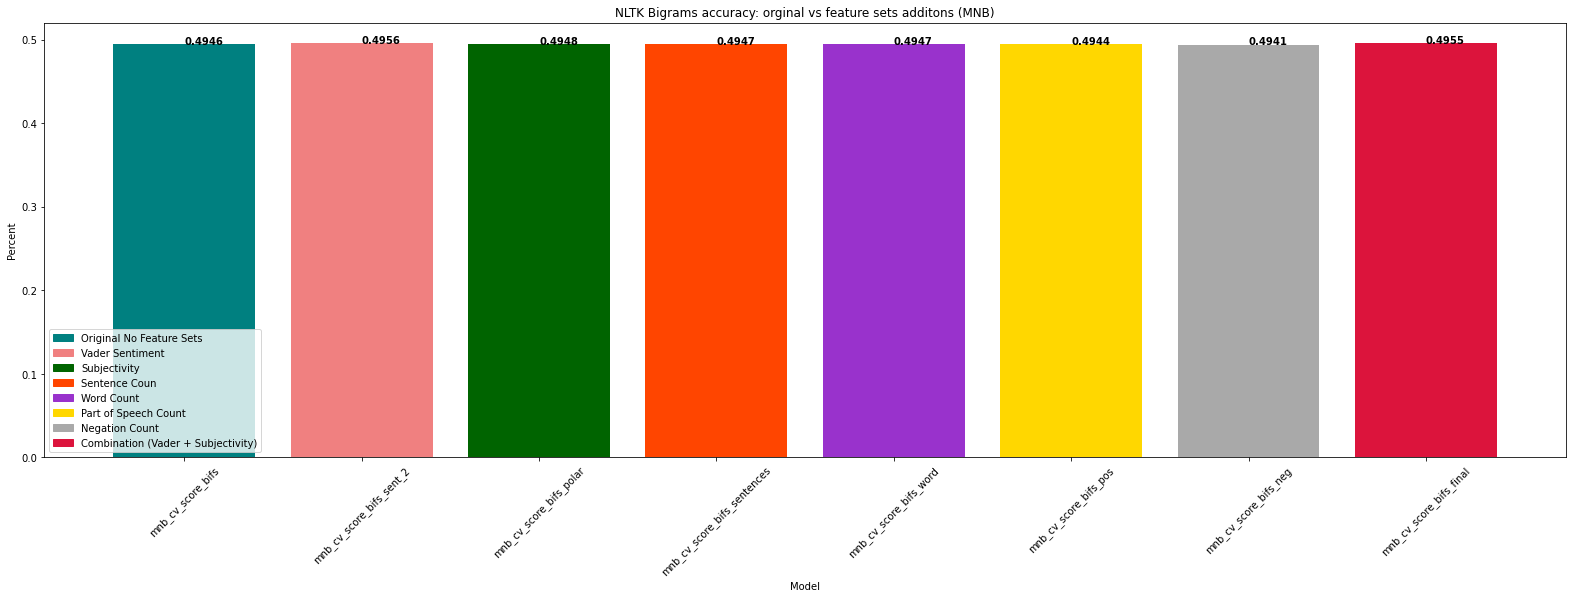

In [144]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# function to add value labels
def addlabels(y):
    for i in range(len(y)):
        plt.text(i,y[i],y[i],fontweight = 'bold')


values = list(mnb_bifs_dict.values())
names = list(mnb_bifs_dict.keys())
colors = ['teal','lightcoral','darkgreen','orangered','darkorchid','gold','darkgray','crimson'
]
plt.figure(figsize=(60, 8))

plt.subplot(121)
plt.bar(names
        ,values
        ,color= colors
       )
plt.xticks(rotation= 45)
#plt.show()
# legend manually added
l1 = mpatches.Patch(color='teal', label='Original No Feature Sets')
l2 = mpatches.Patch(color='lightcoral', label='Vader Sentiment')
l3 = mpatches.Patch(color='darkgreen', label='Subjectivity')
l4 = mpatches.Patch(color='orangered', label='Sentence Coun')
l5 = mpatches.Patch(color='darkorchid', label='Word Count')
l6 = mpatches.Patch(color='gold', label='Part of Speech Count')
l7 = mpatches.Patch(color='darkgray', label='Negation Count')
l8 = mpatches.Patch(color='crimson', label='Combination (Vader + Subjectivity)')




plt.ylabel('Percent')
plt.xlabel('Model')
plt.title('NLTK Bigrams accuracy: orginal vs feature sets additons (MNB)')

addlabels(values)
plt.legend(handles=[l1, l2, l3,l4,l5,l6,l7,l8], loc=3)
plt.show()

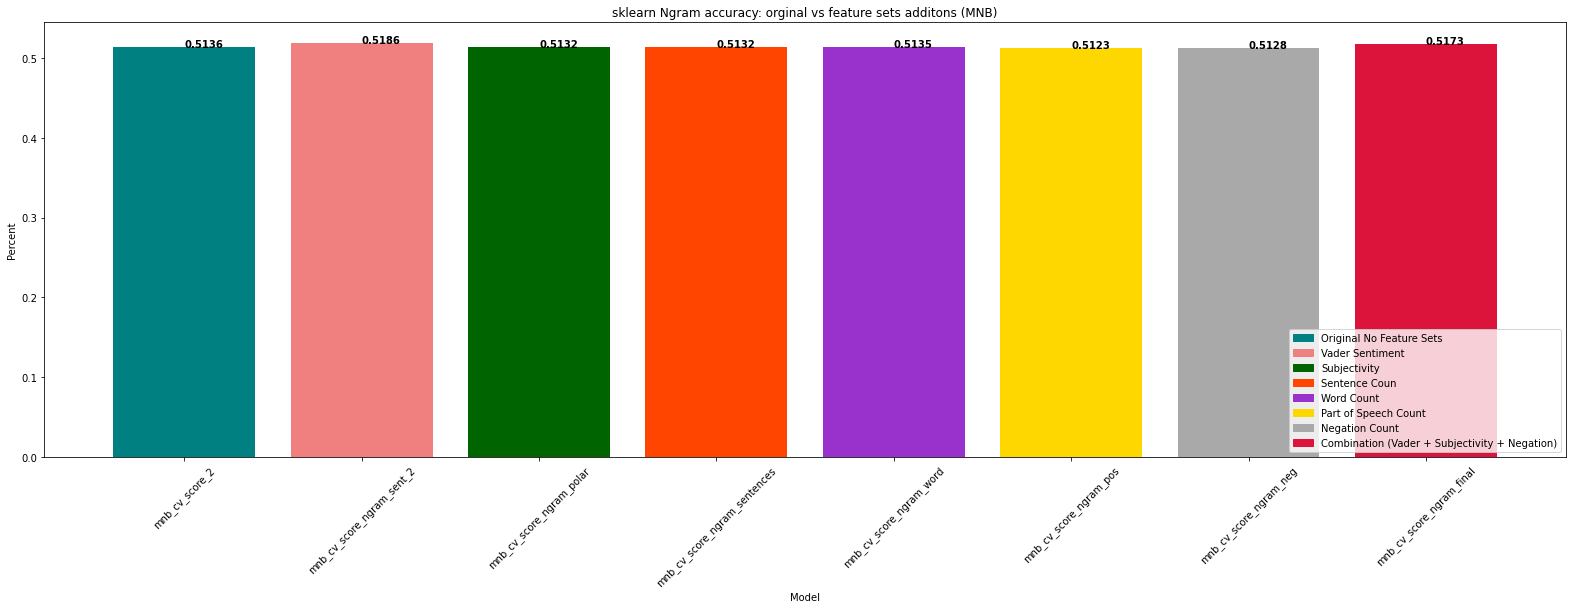

In [145]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# function to add value labels
def addlabels(y):
    for i in range(len(y)):
        plt.text(i,y[i],y[i],fontweight = 'bold')


values = list(mnb_ngram_dict.values())
names = list(mnb_ngram_dict.keys())
colors = ['teal','lightcoral','darkgreen','orangered','darkorchid','gold','darkgray','crimson'
]
plt.figure(figsize=(60, 8))

plt.subplot(121)
plt.bar(names
        ,values
        ,color= colors
       )
plt.xticks(rotation= 45)
#plt.show()
# legend manually added
l1 = mpatches.Patch(color='teal', label='Original No Feature Sets')
l2 = mpatches.Patch(color='lightcoral', label='Vader Sentiment')
l3 = mpatches.Patch(color='darkgreen', label='Subjectivity')
l4 = mpatches.Patch(color='orangered', label='Sentence Coun')
l5 = mpatches.Patch(color='darkorchid', label='Word Count')
l6 = mpatches.Patch(color='gold', label='Part of Speech Count')
l7 = mpatches.Patch(color='darkgray', label='Negation Count')
l8 = mpatches.Patch(color='crimson', label='Combination (Vader + Subjectivity + Negation)')




plt.ylabel('Percent')
plt.xlabel('Model')
plt.title('sklearn Ngram accuracy: orginal vs feature sets additons (MNB)')

addlabels(values)
plt.legend(handles=[l1, l2, l3,l4,l5,l6,l7,l8], loc=4)
plt.show()